In [1]:
import jax

import jax.numpy as np
import jax.scipy as sp

from numpy.polynomial.hermite import hermgauss
import scipy as osp

from vb_lib import structure_model_lib, data_utils, cavi_lib, structure_optimization_lib
from vb_lib.preconditioner_lib import get_mfvb_cov_matmul

import paragami
import vittles

from copy import deepcopy

import time

import matplotlib.pyplot as plt
%matplotlib inline  

from bnpmodeling_runjingdev import cluster_quantities_lib, modeling_lib
from bnpmodeling_runjingdev.sensitivity_lib import get_jac_hvp_fun

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
autograd_results = np.load('./tmp.npz')

In [3]:
import numpy as onp
onp.random.seed(53453)

# Draw data

In [4]:
n_obs = 40
n_loci = 50
n_pop = 4

In [5]:
g_obs, true_pop_allele_freq, true_ind_admix_propn = \
    data_utils.draw_data(n_obs, n_loci, n_pop)

Generating datapoints  0  to  40


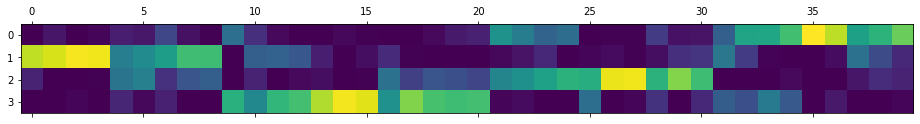

In [6]:
plt.matshow(true_ind_admix_propn.T)

In [7]:
g_obs = np.array(g_obs)

In [8]:
assert np.all(g_obs  == autograd_results['g_obs'])

# Get prior

In [9]:
prior_params_dict, prior_params_paragami = \
    structure_model_lib.get_default_prior_params()

print(prior_params_dict)

prior_params_free = prior_params_paragami.flatten(prior_params_dict, free = True)

{'dp_prior_alpha': DeviceArray([3.], dtype=float64), 'allele_prior_alpha': DeviceArray([1.], dtype=float64), 'allele_prior_beta': DeviceArray([1.], dtype=float64)}


# Get VB params 

In [10]:
k_approx = 8

In [11]:
gh_deg = 8
gh_loc, gh_weights = hermgauss(8)

In [12]:
use_logitnormal_sticks = False

vb_params_dict, vb_params_paragami = \
    structure_model_lib.get_vb_params_paragami_object(n_obs, n_loci, k_approx,
                                    use_logitnormal_sticks = use_logitnormal_sticks)
    
print(vb_params_paragami)

OrderedDict:
	[pop_freq_beta_params] = NumericArrayPattern (50, 8, 2) (lb=0.0, ub=inf)
	[ind_admix_params] = OrderedDict:
	[stick_beta] = NumericArrayPattern (40, 7, 2) (lb=0.0, ub=inf)


## Initialize 

In [13]:
vb_params_dict = \
        structure_model_lib.set_init_vb_params(g_obs, k_approx, vb_params_dict,
                                                seed = 143241)

In [14]:
structure_model_lib.get_kl(g_obs, vb_params_dict, prior_params_dict,
                            gh_loc, gh_weights)

DeviceArray(11000.21932857, dtype=float64)

In [15]:
vb_params_free = vb_params_paragami.flatten(vb_params_dict, free = True)

In [16]:
np.all(vb_params_free == autograd_results['vb_params_free'])

DeviceArray(True, dtype=bool)

# Define objective

In [18]:
optim_objective, vb_params_free = \
    structure_optimization_lib.define_structure_objective(g_obs,
                                                        vb_params_dict,
                                                        vb_params_paragami,
                                                        prior_params_dict, 
                                                        compile_hvp = True)

Compiling objective ...
Iter 0: f = 11000.21932857
Compiling grad ...
Compiling hvp ...
Compile time: 53.7004secs


In [19]:
optim_objective.set_print_every(0)

# Check gradients are the same as autograd

In [20]:
optim_objective.f_np(vb_params_free) - autograd_results['kl']

-3.199784259777516e-08

In [21]:
np.abs(optim_objective.grad_np(vb_params_free) - autograd_results['kl_grad']).max()

DeviceArray(6.37179198e-12, dtype=float64)

In [22]:
np.abs(optim_objective.hvp_np(vb_params_free, vb_params_free) - 
       autograd_results['kl_hvp']).max()

DeviceArray(3.98365785e-10, dtype=float64)

# Derivative times

In [23]:
# function time
%timeit optim_objective.f_np(vb_params_free)

5.32 ms ± 51.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [24]:
# gradient time
%timeit optim_objective.grad_np(vb_params_free)

14.7 ms ± 78 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [25]:
%timeit optim_objective.hvp_np(vb_params_free, vb_params_free)

41.4 ms ± 130 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [26]:
import inspect
lines = inspect.getsource(structure_model_lib.get_e_loglik)
print(lines)


def get_e_loglik(g_obs, e_log_pop_freq, e_log_1m_pop_freq, \
                    e_log_sticks, e_log_1m_sticks,
                    detach_ez):


    e_log_cluster_probs = \
        modeling_lib.get_e_log_cluster_probabilities_from_e_log_stick(
                            e_log_sticks, e_log_1m_sticks)

    with loops.Scope() as s:
        s.e_loglik = 0.
        s.z_entropy = 0.
        for l in s.range(g_obs.shape[1]):
            e_loglik_l, z_entropy_l = get_e_loglik_l(g_obs[:, l],
                                    e_log_pop_freq[l], e_log_1m_pop_freq[l],
                                    e_log_cluster_probs, detach_ez)

            s.e_loglik += e_loglik_l
            s.z_entropy += z_entropy_l

    return s.e_loglik, s.z_entropy

